# Noob2Vec

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re
import csv
import string

In [3]:
import nltk
from nltk.util import ngrams
import gensim.models.word2vec as w2v
from gensim.models import Phrases
from collections import Counter

import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/shu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/shu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [7]:
data_filenames = sorted(glob.glob("data/*.txt"))

In [8]:
print("Found books:",data_filenames)
#data_filenames

Found books: ['data/*.txt']


**Combine the books into one string**

In [9]:
corpus_raw = u""
for data_filename in data_filenames:
    print("Reading '{0}'...".format(data_filename))
    with codecs.open(data_filename, "r", "utf-8") as data_file:
        corpus_raw += data_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data/*.txt'...
Corpus is now 194670485 characters long



**Split the corpus into sentences**

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [13]:
partial_raw_sentences = raw_sentences[0:50] 

In [14]:
# cleanup stopwords from raw_sentences
from nltk.corpus import stopwords 
stopset = set(stopwords.words('english'))
cleanups = [token.lower() for token in partial_raw_sentences if token.lower() not in stopset and len(token)>2]

In [15]:
cleanups

['body\n"nah fam we good\n\n"\n"ok but without caffeine my friend isn\'t motivated to even go out for a run, he just gets sleepy.',
 'maybe he overdid it with the speed?',
 'i mean he has noticed performance improvement on caffeine compared to other stuff, he feels useless without any stimulants.',
 "as in can't get stuff done, brain doesn't work\n\nwhat's a good balance?",
 'just drop the amphetamines?',
 'is the caffeine pill better than cup of coffee?"',
 '"when i was in xc coach said not to eat before running cause i would get cramps and you should not eat 4 hours before running\n\nit was amphetamine powder, kind of yellowish-brown, i think it\'s mostly pure.',
 'does eating before running work for you?',
 'what do you usually eat and how long are your runs"\nbarefoot\nthat sounds.... interesting o_o\nmy friend has a similar story except it was in the winter in alaska and it was a retarded boy who was running that asked to be sprayed and then got blasted.',
 'asics all the way.',
 

In [16]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [17]:
sentences = []
for cleanup in cleanups:
    if len(cleanup) > 0:
        sentences.append(sentence_to_wordlist(cleanup))

In [18]:
len(sentences)

50

In [21]:
sentences[0]

['body',
 'nah',
 'fam',
 'we',
 'good',
 'ok',
 'but',
 'without',
 'caffeine',
 'my',
 'friend',
 'isn',
 't',
 'motivated',
 'to',
 'even',
 'go',
 'out',
 'for',
 'a',
 'run',
 'he',
 'just',
 'gets',
 'sleepy']

In [22]:
print(cleanups[1])
print(sentence_to_wordlist(cleanups[1]))

maybe he overdid it with the speed?
['maybe', 'he', 'overdid', 'it', 'with', 'the', 'speed']


In [24]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,012 tokens


In [25]:
from gensim.models.phrases import Phraser
phrases = Phrases(sentences)
bigram = Phraser(phrases)

2018-01-18 11:04:36,307 : INFO : collecting all words and their counts
2018-01-18 11:04:36,311 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-01-18 11:04:36,316 : INFO : collected 1207 word types from a corpus of 1012 words (unigram + bigrams) and 50 sentences
2018-01-18 11:04:36,318 : INFO : using 1207 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
2018-01-18 11:04:36,322 : INFO : source_vocab length 1207
2018-01-18 11:04:36,338 : INFO : Phraser built with 3 3 phrasegrams


In [27]:
trigram = Phrases(bigram[sentences])

2018-01-17 18:58:30,229 : INFO : collecting all words and their counts
2018-01-17 18:58:30,232 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2018-01-17 18:58:31,174 : INFO : PROGRESS: at sentence #10000, processed 148908 words and 65367 word types
2018-01-17 18:58:32,019 : INFO : PROGRESS: at sentence #20000, processed 293512 words and 118765 word types
2018-01-17 18:58:32,851 : INFO : PROGRESS: at sentence #30000, processed 440445 words and 163790 word types
2018-01-17 18:58:33,668 : INFO : PROGRESS: at sentence #40000, processed 583102 words and 202112 word types
2018-01-17 18:58:34,498 : INFO : PROGRESS: at sentence #50000, processed 728947 words and 238489 word types
2018-01-17 18:58:35,322 : INFO : PROGRESS: at sentence #60000, processed 872150 words and 272638 word types
2018-01-17 18:58:36,143 : INFO : PROGRESS: at sentence #70000, processed 1016062 words and 305663 word types
2018-01-17 18:58:36,949 : INFO : PROGRESS: at sentence #80000, processed 115557

2018-01-17 18:59:32,815 : INFO : PROGRESS: at sentence #740000, processed 10614356 words and 1546064 word types
2018-01-17 18:59:33,632 : INFO : PROGRESS: at sentence #750000, processed 10756857 words and 1560121 word types
2018-01-17 18:59:34,478 : INFO : PROGRESS: at sentence #760000, processed 10904421 words and 1575140 word types
2018-01-17 18:59:35,280 : INFO : PROGRESS: at sentence #770000, processed 11045710 words and 1589832 word types
2018-01-17 18:59:36,155 : INFO : PROGRESS: at sentence #780000, processed 11203191 words and 1605680 word types
2018-01-17 18:59:36,930 : INFO : PROGRESS: at sentence #790000, processed 11341175 words and 1619248 word types
2018-01-17 18:59:37,800 : INFO : PROGRESS: at sentence #800000, processed 11495998 words and 1636210 word types
2018-01-17 18:59:38,589 : INFO : PROGRESS: at sentence #810000, processed 11634691 words and 1650043 word types
2018-01-17 18:59:39,373 : INFO : PROGRESS: at sentence #820000, processed 11774127 words and 1664257 wor

2018-01-17 19:00:33,036 : INFO : PROGRESS: at sentence #1470000, processed 21184505 words and 2497509 word types
2018-01-17 19:00:33,832 : INFO : PROGRESS: at sentence #1480000, processed 21325909 words and 2507774 word types
2018-01-17 19:00:34,711 : INFO : PROGRESS: at sentence #1490000, processed 21480751 words and 2522357 word types
2018-01-17 19:00:35,545 : INFO : PROGRESS: at sentence #1500000, processed 21625553 words and 2532959 word types
2018-01-17 19:00:36,402 : INFO : PROGRESS: at sentence #1510000, processed 21776371 words and 2544870 word types
2018-01-17 19:00:37,203 : INFO : PROGRESS: at sentence #1520000, processed 21917045 words and 2555556 word types
2018-01-17 19:00:38,088 : INFO : PROGRESS: at sentence #1530000, processed 22078228 words and 2565874 word types
2018-01-17 19:00:38,937 : INFO : PROGRESS: at sentence #1540000, processed 22232435 words and 2573269 word types
2018-01-17 19:00:39,707 : INFO : PROGRESS: at sentence #1550000, processed 22373553 words and 25

2018-01-17 19:01:33,606 : INFO : PROGRESS: at sentence #2200000, processed 31897273 words and 3237858 word types
2018-01-17 19:01:34,455 : INFO : PROGRESS: at sentence #2210000, processed 32049466 words and 3248589 word types
2018-01-17 19:01:35,296 : INFO : PROGRESS: at sentence #2220000, processed 32196371 words and 3258169 word types
2018-01-17 19:01:36,079 : INFO : PROGRESS: at sentence #2230000, processed 32338545 words and 3267601 word types
2018-01-17 19:01:36,875 : INFO : PROGRESS: at sentence #2240000, processed 32479962 words and 3276953 word types
2018-01-17 19:01:37,706 : INFO : PROGRESS: at sentence #2250000, processed 32627964 words and 3286466 word types
2018-01-17 19:01:38,533 : INFO : PROGRESS: at sentence #2260000, processed 32777739 words and 3296496 word types
2018-01-17 19:01:39,360 : INFO : PROGRESS: at sentence #2270000, processed 32922444 words and 3306106 word types
2018-01-17 19:01:40,197 : INFO : PROGRESS: at sentence #2280000, processed 33072142 words and 33

In [28]:
sent = [u'fleur', u'de', u'peau', u'new', u'york', u'lunar', u'elite', u'hello', u'me']
>>> print((trigram[bigram[sent]]))

['fleur', 'de', 'peau', 'new_york', 'lunar', 'elite', 'hello', 'me']


/Users/shu/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:486: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
new_stuff= list((trigram[bigram[sentences]]))

/Users/Lucas.Galan/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [23]:
print(new_stuff[22])

['daaamn']


In [27]:
print(trigram[bigram[sentences[57]]])

['i', 'take', 'it', 'seriously']


/Users/Lucas.Galan/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


## Train Word2Vec

## Train Word2Vec

In [51]:
# Dimensionality of the resulting word vectors.
num_features = 300

# Minimum word count threshold.
min_word_count = 5

# Number of threads to run in parallel.
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 15

# Downsample setting for frequent words.
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
seed = 1

In [52]:
model2vec = w2v.Word2Vec(
    sg=0,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [53]:
model2vec.build_vocab(new_stuff)

2018-01-05 10:27:13,319 : INFO : collecting all words and their counts
2018-01-05 10:27:13,322 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-01-05 10:27:13,352 : INFO : PROGRESS: at sentence #10000, processed 141753 words, keeping 11164 word types
2018-01-05 10:27:13,383 : INFO : PROGRESS: at sentence #20000, processed 283032 words, keeping 15561 word types
2018-01-05 10:27:13,411 : INFO : PROGRESS: at sentence #30000, processed 422757 words, keeping 18575 word types
2018-01-05 10:27:13,441 : INFO : PROGRESS: at sentence #40000, processed 566340 words, keeping 20935 word types
2018-01-05 10:27:13,470 : INFO : PROGRESS: at sentence #50000, processed 704389 words, keeping 22980 word types
2018-01-05 10:27:13,500 : INFO : PROGRESS: at sentence #60000, processed 844957 words, keeping 25036 word types
2018-01-05 10:27:13,534 : INFO : PROGRESS: at sentence #70000, processed 987007 words, keeping 26729 word types
2018-01-05 10:27:13,567 : INFO : PROGRESS: at 

In [54]:
print("Word2Vec vocabulary length:", len(model2vec.wv.vocab))

Word2Vec vocabulary length: 11686


**Start training, this might take a minute or two...**

In [55]:
model2vec.train(new_stuff, total_examples=model2vec.corpus_count, epochs=model2vec.iter)

2018-01-05 10:27:17,549 : INFO : training model with 8 workers on 11686 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=15
2018-01-05 10:27:18,565 : INFO : PROGRESS: at 22.49% examples, 1279711 words/s, in_qsize 16, out_qsize 0
2018-01-05 10:27:19,571 : INFO : PROGRESS: at 45.18% examples, 1281579 words/s, in_qsize 14, out_qsize 1
2018-01-05 10:27:20,578 : INFO : PROGRESS: at 67.69% examples, 1279454 words/s, in_qsize 15, out_qsize 0
2018-01-05 10:27:21,588 : INFO : PROGRESS: at 90.64% examples, 1282966 words/s, in_qsize 16, out_qsize 1
2018-01-05 10:27:21,979 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-01-05 10:27:21,982 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-01-05 10:27:21,984 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-01-05 10:27:21,988 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-01-05 10:27:21,995 : INFO : worker thread finished; awaiting

5703361

**Save to file, can be useful later**

In [56]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [57]:
model2vec.save(os.path.join("trained", "guitar1.w2v"))

2018-01-05 10:27:31,950 : INFO : saving Word2Vec object under trained/guitar1.w2v, separately None
2018-01-05 10:27:31,952 : INFO : not storing attribute syn0norm
2018-01-05 10:27:31,953 : INFO : not storing attribute cum_table
2018-01-05 10:27:32,236 : INFO : saved trained/guitar1.w2v


In [31]:
model2vec.wv.save_word2vec_format('guitar.bin', binary=True)

2018-01-04 13:23:28,333 : INFO : storing 11686x512 projection weights into guitar.bin


## Explore the trained model.

In [17]:
model2vec = w2v.Word2Vec.load(os.path.join("trained", "furniture.w2v"))

2018-01-15 11:47:29,512 : INFO : loading Word2Vec object from trained/furniture.w2v
2018-01-15 11:47:30,021 : INFO : loading wv recursively from trained/furniture.w2v.wv.* with mmap=None
2018-01-15 11:47:30,022 : INFO : setting ignored attribute syn0norm to None
2018-01-15 11:47:30,028 : INFO : setting ignored attribute cum_table to None
2018-01-15 11:47:30,029 : INFO : loaded trained/furniture.w2v


In [269]:
from sklearn.decomposition import PCA, FastICA
import hdbscan

In [270]:
class Decomposer():
    def __init__(self, n_components=15, copy=True, whiten=True, mode="pca", max_iter=2000, model=None):
        if model is not None:
            self.model = model
        else:
            if mode == "pca":
                self.model = PCA(n_components=n_components, copy=copy, whiten=whiten)
            elif mode == "ica":
                self.model = FastICA(n_components=n_components, whiten=whiten, max_iter=max_iter)
    def fit(self, X):
        self.model.fit(X)

    def transform(self, X):
        return self.model.transform(X)

    def fit_transform(self, X):
        data = self.model.fit_transform(X)
        return data

In [271]:
decomposer = Decomposer(n_components=15)
X_decomp = decomposer.fit_transform(model2vec.wv.syn0)

In [272]:
class HDBscanClusterer():
    _min_cluster_size = 15
    _metric = "euclidean"

    def __init__(self, min_cluster_size=15, min_samples=1, alpha=1.0, metric="euclidean"):
        self.min_cluster_size = min_cluster_size
        self.min_samples = min_samples
        self.alpha = alpha
        self.metric = metric
        self.labels = []

    @property
    def min_cluster_size(self):
        return self._min_cluster_size

    @min_cluster_size.setter
    def min_cluster_size(self, value):
        self._min_cluster_size = value

    @property
    def metric(self):
        return self._metric

    @metric.setter
    def metric(self, value):
        self._metric = value

    @property
    def labels(self):
        return self._labels

    @labels.setter
    def labels(self, value):
        self._labels = value

    def cluster(self, X):
        model = hdbscan.HDBSCAN(min_cluster_size=self.min_cluster_size, min_samples=self.min_samples, alpha=self.alpha, metric=self.metric)
        labels = model.fit_predict(X)
        self.labels = [{'index': i, 'cluster': j} for i, j in enumerate(labels)]


In [273]:
from sklearn.preprocessing import normalize
class L2Normalizer():
    def norm(self, X):
        return normalize(X, norm='l2')


In [274]:
X_decomp_norm = L2Normalizer().norm(X_decomp)

In [275]:
df = pd.DataFrame(X_decomp_norm)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.130999,0.527621,0.210221,0.189247,-0.063656,0.193497,-0.198880,0.245758,-0.128961,-0.047168,0.376972,-0.171751,-0.236535,-0.486363,-0.006684
1,0.014379,0.430065,0.223736,0.289070,0.110650,0.030323,-0.199272,-0.132640,-0.021920,-0.200390,-0.078423,0.511021,0.124671,-0.079195,-0.530103
2,-0.180253,0.089400,0.078143,0.096990,-0.072008,0.587946,-0.021498,-0.460335,0.070749,-0.327258,0.414596,0.179709,0.155212,-0.041812,0.196571
3,-0.256323,0.262195,0.142109,0.279783,0.072577,0.099526,-0.326237,-0.150616,-0.559395,0.131370,0.250457,0.370294,-0.082193,-0.202089,-0.212525
4,-0.163120,0.291727,-0.027068,0.383413,0.114631,-0.265923,-0.307298,0.065232,-0.060799,-0.069435,0.515328,0.234172,0.223882,-0.405200,-0.121569
5,-0.181103,0.312324,0.054210,0.260575,-0.103507,0.431211,-0.104843,-0.231638,-0.144123,-0.381627,-0.204292,0.041738,0.237721,0.002601,-0.520678
6,-0.159599,0.235980,0.139869,0.429549,0.177904,0.076942,0.240279,-0.062983,-0.528748,-0.265219,0.101940,0.355124,-0.006036,0.213995,-0.288522
7,-0.154718,0.263743,0.081535,0.240715,0.144763,-0.138740,-0.157140,0.311024,-0.023840,0.181179,0.306247,-0.365996,-0.186665,-0.611273,0.103164
8,-0.239116,0.299677,0.074615,0.247279,0.066566,0.283237,-0.206802,-0.130779,-0.173880,-0.684920,0.296394,-0.185543,-0.138071,-0.030064,-0.013632
9,-0.153039,0.076220,-0.051770,-0.170558,-0.068705,-0.038349,0.012703,0.201333,0.227680,0.373845,-0.610396,-0.310823,-0.434254,-0.056650,-0.198830


In [303]:
hdb = HDBscanClusterer(min_cluster_size=8, min_samples=1, alpha=0.25)
hdb.cluster(X_decomp_norm)

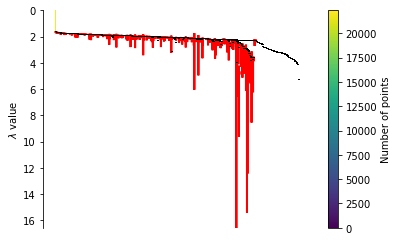

In [214]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1, alpha=0.25).fit(X_decomp_norm)
clusterer.condensed_tree_.plot(select_clusters=True,
selection_palette=sns.color_palette('deep', 8))

In [297]:
df = pd.DataFrame(X_decomp_norm)

In [293]:
len(df)

22355

In [298]:
res = hdb.labels
vocab_map = model2vec.wv.vocab
df = pd.DataFrame(res)
df = df[df['cluster'] > -1]
counts = df['cluster'].value_counts().to_dict()
good = {k: v for k, v in counts.items() if v < 1000}
df['ok'] = df['cluster'].apply(lambda x: x in good)
df = df[df['ok']]
n_clusters = len(df['cluster'].unique())
print("FOUND {} CLUSTERS".format(n_clusters))

FOUND 143 CLUSTERS


In [252]:
data_df = pd.DataFrame.from_dict(model2vec.wv.vocab, orient='index', dtype=None)
data_df.head(10)


,0
body,"Vocab(count:95, index:2827, sample_int:4294967..."
what,"Vocab(count:14463, index:31, sample_int:333690..."
ever,"Vocab(count:811, index:502, sample_int:4294967..."
colour,"Vocab(count:1356, index:322, sample_int:429496..."
that,"Vocab(count:55619, index:8, sample_int:1418735..."
they,"Vocab(count:12354, index:41, sample_int:371094..."
are,"Vocab(count:22048, index:24, sample_int:252837..."
not,"Vocab(count:17233, index:26, sample_int:296998..."
but,"Vocab(count:29461, index:14, sample_int:210061..."
as,"Vocab(count:13203, index:35, sample_int:354774..."


In [299]:
df['raw_vector'] = df['index'].apply(lambda x: model2vec.wv.syn0[x])
# df['word'] = df['index'].apply(lambda x: model2vec.wv.vocab[x])
df['decomp_norm_vector'] = df['index'].apply(lambda x: X_decomp_norm[x])
len(df.index)
df.head(300)
len(df)

2344

In [300]:
df.to_csv('furniturehdb1.csv')

In [40]:
df.head(300)

,cluster,index,ok,raw_vector,decomp_norm_vector
5,3,5,True,"[0.356233, -0.392705, -0.692795, 0.053219, -0....","[0.272821, -0.231888, 0.0653696, 0.0975454, -0..."
9,1,9,True,"[0.230755, -0.745588, 0.635869, -0.297405, -0....","[0.1881, -0.286135, 0.144837, 0.143791, 0.3218..."
15,1,15,True,"[0.325803, -0.858124, -0.109262, -0.216495, 0....","[0.0993332, -0.364573, 0.0365472, 0.146937, 0...."
23,12,23,True,"[0.473244, 1.50857, -0.150483, 0.513225, 0.856...","[0.130658, -0.136518, 0.0999083, -0.141805, -0..."
27,1,27,True,"[0.368035, -0.451515, -0.393489, -0.266516, 0....","[0.274651, -0.246905, -0.105683, 0.21008, 0.39..."
44,10,44,True,"[0.725583, 0.819529, 0.116128, 0.0400276, 2.74...","[0.655209, 0.167355, 0.253003, 0.176138, 0.324..."
54,18,54,True,"[-0.638295, -0.494825, 1.42494, 0.732191, -0.1...","[-0.142935, -0.039733, -0.212737, 0.13114, 0.3..."
61,19,61,True,"[0.0528044, 1.29676, -0.0919555, -0.163556, 0....","[0.133352, -0.431203, -0.0661803, 0.563853, -0..."
64,12,64,True,"[0.229338, 0.406777, -0.769216, 0.296379, -0.5...","[0.0568464, -0.292135, -0.0238861, -0.163191, ..."
80,10,80,True,"[0.512519, 1.15646, -0.186402, 0.179879, 1.804...","[0.541655, 0.193305, 0.568261, 0.135249, 0.215..."


In [46]:
for w in model2vec.wv.vocab:
     print(w,model2vec.wv.vocab[w].count)

title 140
learn 5832
the 71667
intro 336
and 38998
main 216
solo 1362
to 50311
layla 15
unplugged 26
a 46425
lick 512
day 841
check_out 491
my 6271
play 9107
click 198
links 134
start 2781
learning 3224
am 1852
backing_track 319
blues 1317
over 2412
chord_changes 275
bpm 168
open_g 92
cult 10
guitar 10249
lesson 2530
on 13182
gibson 72
string 2027
j 123
i 46443
need 2489
twice 90
year 366
what 7141
kind 43
would_be 1041
good 4314
for 16158
me 3871
about 3496
of 22801
many_benefits 7
easy 1279
lessons_for_beginners 20
in 16946
d 4321
play_perfect_solos 9
one 5682
tab 981
tablature 75
pdf 242
songbooks 11
trade 10
how 5727
well 1095
do 6440
you 45339
know 3543
your 9037
nps 29
scales 2315
oc 43
friends 199
are 10629
worst 57
teachers 261
style 752
improvise_perfect_solos 7
tunings 106
try 2848
from 4346
jimi_hendrix 93
sonic_youth 6
amp 1356
articles 54
tips 319
services 11
arpeggios 429
by 3612
guitarist 454
les 7
de 51
base 119
la_guitare 5
shred 130
course 619
nostalgia 7
sungha_jung 

collins 9
mississippi_john_hurt 37
beautifully 16
murder 12
born 32
under 250
sign 44
cream 16
main_riff 38
wo 5
larry 9
carlton 6
bb_king 38
john_mayer 76
effective 81
popular 112
view 115
giuliani 7
recommended 55
major_triad 34
sequence 125
based_on 187
diminished 160
harmonics 48
power 103
acquainted 7
weeknd 6
breakdown 34
understanding 426
applied 41
numbers 108
working_through 25
sounding 218
sitting 113
by_camilo_james 6
string_skipping 23
alternate_picking 164
pattern 654
why 1259
hand 551
coordination 33
getting 944
hang 107
arpeggio 184
fragments 21
exotic 21
master_of_puppets 24
rythm 21
mailing 8
warmups 11
delivered 12
every 964
alternating_bass 14
fingerpicking_patterns 10
ii 106
symbols 13
children 50
finger_dexterity 26
stress 64
balls 15
random 124
dropped 40
cake 19
ocean 13
open 717
double_stops 26
slide 317
distortion 107
amazing 290
finally 221
jerry_garcia 17
uncle 15
pt 20
comping 39
paul_mccartney 13
henry 5
underlying 29
chord_tones 226
especially 444
thirds 4

old_school 16
road 70
dan 35
oz 8
opening 43
interview 17
sliding 74
delta 39
mastery 29
he_does 115
front 33
rolls 10
drumming 17
fresh 43
jon 9
pathways 7
raking 11
searched 24
haven_t 193
anything 788
wild 31
bands 157
demon 7
secrets 27
biggest 87
earth 27
blossom 5
bluegrass 74
tony_rice 13
tin 10
america 19
finished 48
savage 6
pointers 19
tracks 89
sources 34
bullets 6
fear 30
catalogue 6
smash 9
fields 8
stand_by_me 13
string_sets 14
mon 7
symmetrical 5
leonard 6
cohen 5
san 7
area 127
music_notation 23
lay 43
times 360
masterclass 24
main_theme 6
tremonti 6
given 199
mark 53
dave 56
frank 12
nature 44
android_app 14
containing 8
famous 70
practise 88
pulling 38
apart 71
natural_harmonics 10
trick 147
smoothly 44
across 257
diatonic_scales 30
mediocre 18
self_taught 86
extremely_important 10
iz 5
somewhere 126
levels 49
awareness 20
musician 249
half 316
focusing_on 117
progressive 22
walking_bass 17
discuss 25
tritone 29
red 62
flies 6
via 76
key_signatures 41
travis 13
tasty 

rule 101
their_own 131
blog_posts 7
per_week 25
enjoyed 100
hints 8
nick_drake 10
reliable 22
focussed 6
o_clock 22
thrones 12
josh 26
turner 6
doable 21
guilty 10
absolute_fretboard_mastery 7
flaws 15
exact 108
correct 476
knows 89
should_be_able 133
detail 55
percussive 42
on_mobile 50
advance 50
most_people 144
greek 5
simpsons 5
auto 18
lee 20
function 53
ear_trainer 5
store 118
following 144
silly 54
uh 31
steel_string_acoustic 9
your_favourite 18
youtube_channels 19
matching 18
allman_brothers 24
blue_sky 8
sight_read 22
my_wrist 47
bending 120
fair_bit 19
fat_fingers 13
touching 60
neighboring 5
my_mom 11
lazy 60
eye 38
paul_gilbert 52
creating 119
images 63
print 31
stella_by_starlight 9
alan 13
guitar_pro 78
general 119
biscuit 5
buy 344
premium 23
been_playing_for 54
variety 75
wicked_game 7
rather 119
decide 114
joe_bonamassa 12
allan 5
holdsworth 17
gravity 13
instead_of 516
trough 8
hundreds_of 32
strong 100
records 35
dropped_d 12
missed 70
map 43
team 11
instinct 11
your

vague 30
accomplish 35
gotten 55
copy 85
jk 7
gets 344
accidental 10
native 12
english 72
speaker 17
language 123
https_en_wikipedia_org 139
wiki 159
safe 32
sharps 73
flats 70
accidentals 29
naming 20
http_www_fachords_com 25
cyber 5
wasn_t 209
steal 20
axe 24
commenting 46
mine 197
pretty_good 184
m_curious 21
squier_affinity 6
telecaster 26
squier 44
classic_vibe 15
strat 125
wow 241
ve_seen 134
nit 7
picky 10
appropriate 70
situation 90
dick 54
press 99
an_issue 49
gear 128
terrible 88
spreading 12
misinformation 7
pinched 7
usually 580
pointer 11
your_picking_hand 33
outlining 7
sweet_spot 20
shared 33
coming_up 24
obvious 113
artists 86
grip 121
mayer 24
seen 114
report 11
spam 51
an_advantage 13
didn_t_realize 20
convert 12
readers 8
impact 32
negatively 5
hey_thanks_for 37
deeper_into 8
notice 248
beginner_level 17
source 130
gave 84
appreciate 250
deleted_deleted_deleted_deleted 132
joined 14
puzzle 6
ambiguous 12
text 59
removed_deleted_deleted_deleted 16
pretty_simple 50
v_i

emphasis 33
basic_theory 45
misunderstanding 12
musical_idea 12
jump_into 11
forums 19
lack 36
chord_construction 24
individually 35
each_other 152
church 14
prominent 9
stem 5
zero 56
grasp 78
theoretical 27
educate 7
skipping 29
re_looking 85
contemporary 16
iron 27
wine 25
row 53
rotate 21
clockwise 6
ring 153
rotating 7
your_hand 329
relative_minor 83
monday 19
shots 11
relatives 5
equal 37
fwiw 18
bryan 6
arched 8
hand_position 30
relaxed 74
strumming_hand 23
blocked 17
audacity 32
slow_down 93
without_changing 13
every_week 38
an_actual 34
gradual 13
consistent 86
daily_practice 18
skill 209
getting_frustrated 12
keep_practicing 112
properly_set_up 8
so_forth 30
refine 10
observed 5
players_who 23
fretting 187
crush 6
banging 11
boils_down 9
lighter_strings 15
needing 22
smaller 82
expecting 24
email 53
fee 12
pages 44
easier_than 43
unlearning 6
both_ways 31
classical_style 20
puts 36
single_note 60
baseball_bat 8
stable 14
classical_position 15
four_frets 16
stronger 71
injurie

complement 12
sharkey 5
np 19
hey_thanks 36
ve_never_seen 31
wondering_if 13
ringing 21
vibrate 17
tell_us 11
keep_listening 15
taj_mahal 6
akin 7
drilling 13
your_own_style 16
evolve 11
popular_music 19
landed 6
goodbye 13
yellow 19
realizing 21
leaves 23
intent 12
isnt 32
features 60
overtones 11
ve_been_wanting 15
daunting 24
aolian 6
ionian 91
c_ionian 19
typically 107
centered_around 9
causing 33
drawing 20
notes_per 18
playable 27
phone_app 8
gary 11
foremost 14
re_asking 31
brush_up 8
balance 29
miller 11
dobro 5
intonation 73
thanksgiving 5
struggle 75
shoot 24
told_him 11
drives 12
nuts 22
ridiculous 39
benefit_from 29
correlation 5
sixth_string 17
uploading 18
few_weeks 83
ve_taught 19
communicate 34
highway 13
shifted 17
capos 28
buzzing 32
zepplin 8
substitute 33
experiment 53
flat_third 10
uq 5
holidays 12
scratch 21
th_string 223
universal 21
amp_gclid 8
pla 8
device 33
second_fret 45
curiosity 14
entry_level 15
classical_guitars 13
additional 46
falls 34
backward 8
forwa

don_t_worry 24
tripped 5
td 6
mission 7
newer 28
familiar 42
future_reference 6
thomann 6
harley_benton 6
birthday 13
tuners 48
tab_pro 12
interpret 13
drum_tracks 9
lifelong 7
subscription 33
relatively 60
nowadays 19
shorter 41
bite_sized 8
depend_on 18
in_my_head 58
few_months 81
prepare 11
practice_schedule 19
timer 24
ensure 23
activities 5
instinctively 8
never_understood 10
past_few_years 6
spinning 7
relaxation 6
definitely_check 8
barre_cords 7
dense 7
mainstream 12
ending 52
east 7
poison 9
every_rose_has 6
thorn 8
cliffsmithguitarlessons_co_uk 7
succinct 6
bland 6
shoot_me 24
semi_tones 6
tb 5
semi_tone 9
applicable 27
replace 55
bow 9
temporarily 9
low_action 11
so_much_easier 25
stumbled 16
led_me 8
develop_your_own 15
discount 16
drunk 29
several_years 19
everyone_learns 14
clamping 5
pull 105
reduces 7
define 32
my_head 59
packs 12
pulled 15
trigger 7
plate 6
ground 51
aint 14
fascinating 18
functional 12
complaining 14
registers 8
rhapsody 6
dlc 16
uberchord_com 11
my_d

nine 17
johnny_cash 24
vote 30
surfpick 5
planet 11
someday 33
caused 9
subdominant 6
technically_correct 10
umbrella 7
get_too_hung 7
retrospect 5
rings 14
hells 5
fiddle 22
gal 5
whose 29
transcribing 62
interact 7
heaviest 6
fluent 20
doh 6
kitchen 8
my_phone 17
merit 10
classical_players 10
kudos 10
assumes 9
environment 19
unrelated 11
cadence 12
killing 18
familiarity_with 13
circles 26
swim 6
dope 11
norwegian_wood 6
rhythmically 17
kit 27
rush 38
align 7
grid 9
din 5
apparent 12
geometry 14
mentions 21
pet 6
subjects 5
resonates 6
filled_with 10
food 23
constitutes 6
free_version 19
affiliate_links 7
effectively 62
painting 12
shout 13
actively 29
behavior 7
beforehand 8
opportunity 36
via_skype 13
sidebar 39
hire 16
contrary 9
being_said 6
anywhere_else 14
overrated 6
sports 10
reversed 7
manufacturers 5
self_conscious 7
geared_towards 13
namely 6
more_effective 13
frequent 10
frees_up 6
amen 10
game_changer 19
wrap 39
modern_method 13
events 10
wedding 13
spoken 8
false 24
hi

corrected 16
obstacle 10
classical_pieces 7
plans 18
dig_into 14
hardest_thing 7
pretty_straight_forward 13
ring_middle 8
repeat_repeat 5
marathon 5
leg 25
stressed 9
too_much_pressure 10
stressing 10
most_welcome 12
buckingham 6
customs 5
thousands_of_songs 10
get_familiar_with 31
stayed 13
very_quickly 27
trill 8
po 10
north 12
stars 9
concentrating_on 16
print_out 12
bottom_line 12
ll_be_amazed 7
guitargate 13
d_be_surprised 12
utilize 24
adblock 13
pulls 19
guitarpro 10
port 8
separation_between 6
separating 5
auto_pilot 9
without_thinking 17
dave_grohl 7
condescending 7
sums 7
potentially 13
upgraded 7
vim 9
iim 6
imaj 6
grind 22
box_shapes 23
lydian_dominant 7
implemented 7
mistaken 14
daily_routine 7
edition 19
polished 7
named 39
ross 5
influenced_by 12
moments 28
satisfying 21
overlap 17
coming_up_with 21
approaches 34
entirety 10
finishing 13
arrived 7
thinner 42
forgot 69
jazz_iii 10
xl 5
opened 22
cube 5
presets 8
thr 6
yamaha_pacifica 6
design 32
biggie 5
cycle 21
hobbies 

beside 9
packington 7
sfw_gt 8
ballads 7
british 18
writes 8
copies 10
national 12
cutting 19
plot 8
parent_commenter_can 12
toggle_nsfw_message_compose 7
autowikibot_amp_subject_autowikibot 14
nsfw_toggle_amp_message 7
btoggle_nsfw 7
or_delete_message 7
deletion_amp_message_bdelete 7
on_comment_score 8
faqs_http_www_np 8
reddit_com_r_autowikibot 7
wiki_index_mods_http 7
www_np_reddit_com 7
r_autowikibot_comments 7
moderators_switches_commands 7
css_magic_words 7
http_www_np_reddit 9
com_r_autowikibot_comments 7
ux_ask_wikibot 7
usage 11
adapted 8
image_https 9
commons 9
wikimedia_org 9
wiki_file 5
characteristic 7
outer 7
finger_tips 37
downward 29
index_middle_ring 8
privacy 7
rights 6
occurs 10
certainty 6
substantial 5
latency 7
isn_t_necessary 8
bluetooth 5
correct_answer 15
caused_by 9
playability 21
firstly 12
repairer 28
dozens_of 16
identified 6
diagnose 6
mexican 13
referred 34
isley 6
chase 6
appropriately 6
relief 19
consists_of 29
wire 19
seated 8
warped 7
uneven 7
assess 

saxophone 10
convincingly 6
aimlessly 8
faces 8
emotions 9
stevie 8
deaf 7
opposed 6
connection_between 7
addictive 7
watch_playlist_amp 9
jxkx 5
feature_playlist 9
https_youtube_com 23
https_reddit_com 17
carole 5
bot_working_hard 9
help_redditors_find 9
related_videos 11
info_https_np_reddit 19
com_r_subtletv_wiki 9
mentioned_videos 9
graphics 15
monitor 11
labeled 13
bloody 9
thunder 7
caps 5
fore 5
adams 5
wait_until 15
callus 21
shower 7
solid_body 11
annotations 8
phish 35
geared 6
trey 11
shout_out 14
repeating_patterns 7
long_winded 7
cultivate 5
limitless 5
representations 5
gospel 10
explicitly 12
item 15
keeping_track 7
breathing 14
far_away 12
strung 12
aspx 11
pacing 6
bpms 5
relative_pitch 15
recognising 6
pigs 6
loudly 6
downside 17
broken_down 16
favourite_songs 12
unexpected 7
association 5
ve_ever_heard 12
hood 5
pristine 5
disaster 5
adorable 5
commenters 6
re_enjoying 11
dorian_phrygian 5
shell 16
lighten 5
tonedear 5
inbetween 6
aimed 8
sixteenth_notes 13
cheers_ma

half_quarters 8
eighth_beat 9
quarter_eighths 8
sixteenth_beat 8
eighth_sixteenths 8
fast_they_aren 8
sixteenth_ths 8
create_new_rhythms 8
using_durations_from 8
stack_th_notes 8
lots_of_rhythms_focus 8
on_accentuating_either 8
remember_mute 8
numbers_are_downwards 8
drum_set_finally 8
subdivide 17
lower_three 8
paul_gilbert_shows 9
be_g_byihq 8
j_u_t 8
skills_required 8
bots 6
quick_fix 11
concentrating 5
smoke 9
restrict 11
earphones 5
losing 18
illustrates 5
customers 8
com_message_compose 10
autowikiabot 5
amp_subject 5
cp 8
wiki_index_source 6
https_github_com 9
whack 6
facilitate 8
feels_right 14
curl 16
playlist_list_pl 5
yikes 8
tock 6
straighten 6
an_amateur 8
destroying 5
annotate 5
pleasant 14
va 6
pickup_height 6
relative_minors 11
summarize 6
bus 12
no_idea_what 10
cooley 5
tighter 6
knots 5
deconstruct 7
bob 22
knock 13
misc 6
dummy 5
intelligence 7
concerts 8
beaten 5
meditation 5
metric 10
weezer 8
spread_out 9
listed_above 8
romance 8
polishing 7
per_hour 9
rite 6
ball

lurk 5
circled 6
wording 5
disrespect 6
dice 5
jenslarsen_nl 5
gabriella 5
agile 7
bearing 5
bottoms 5
boxed 5
http_www_thomasberglundguitarlessons_com 29
tabsnotes_ewexternalfiles 25
transcribed_lines 6
oct 8
amp_list_pl_bkerx 8
solder 16
soldering 10
wires 6
bot_info_r_youtubefactsbot 29
wiki_index_gt 26
sep 5
gt_views_since 7
baritone 7
http_subtletv_com_r 15
xxht 5
nline 5
tomo 5
feature_playlist_amp_ftrlnk 7
mentioned_videos_for 14
redd_fiimkmdalmgffhibfdjnhljpnigcmohf_firefox 7
https_addons_mozilla_org 7
en_us_firefox_addon 7
dlar 5
watch_v_o 9
mxr 6
downward_pick 9
slanting 7
trading 5
division 5
ditch 7
lovely_week 8
quick_licks 26
http_guitar_thebigoh 8
linkin_park 7
videogames 5
frankenstein 7
wallpaper 10
jay 6
fuck_motha 6
smokin 8
drinkin 5
blunts 8
ou 7
opt_out_permanently_section 8
content_title 8
grass 7
unpopular 5
amp_ab_channel 8
nashville_numbering 6
regal 14
ensemble 10
squires 5
awkwardness 5
soaking 5
anniversary 5
lemme 5
strongly_recommend 6
la_grange 8
brad 5


In [47]:
data_df = pd.DataFrame.from_dict(model2vec.wv.vocab, orient='index', dtype=None)

In [48]:
data_df.to_csv('guitarwords.csv')

## Train Word2Vec

### Compress the word vectors into 2D space and plot them

In [38]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0, perplexity=5.0, early_exaggeration=12.0, learning_rate=200.0, n_iter=1000, n_iter_without_progress=300)

In [43]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [39]:
all_word_vectors_matrix = model2vec.wv.syn0

**Train t-SNE, this could take a minute or two...**

In [40]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [41]:
from sklearn.cluster import KMeans;

**Plot the big picture**

In [42]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model2vec.wv.vocab[word].index])
            for word in model2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [43]:
pointsforcolor = pd.DataFrame(
    [
        (coords[0], coords[1])
        for coords in [
            (all_word_vectors_matrix_2d[model2vec.wv.vocab[word].index])
            for word in model2vec.wv.vocab
        ]
    ],
    columns=["x", "y"]
)

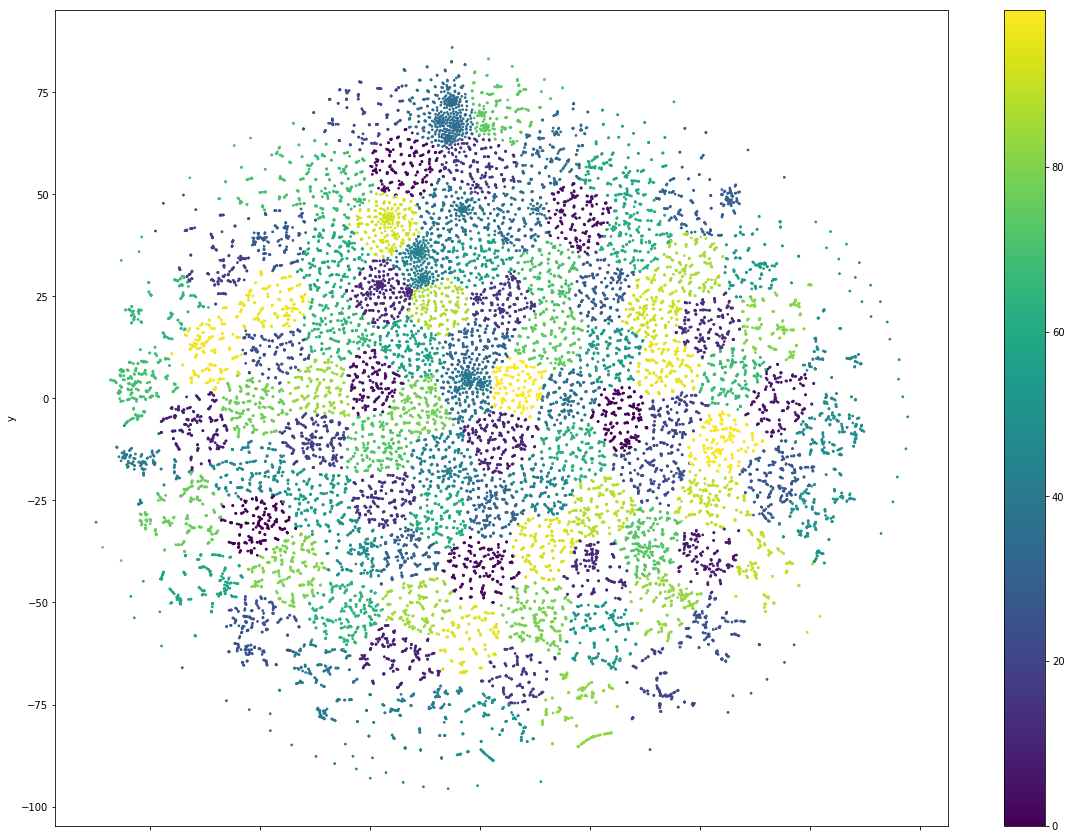

In [44]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100)
kmeans.fit(pointsforcolor)
y_kmeans = kmeans.predict(pointsforcolor)
pointsforcolor.plot.scatter("x", "y", c=y_kmeans, s=3, cmap='viridis', figsize=(20, 15))
points['kmeans'] = y_kmeans

In [152]:
pointsforcolor.head(10)
points.to_csv('ps4coords.csv')

In [50]:
sns.set_context("poster")

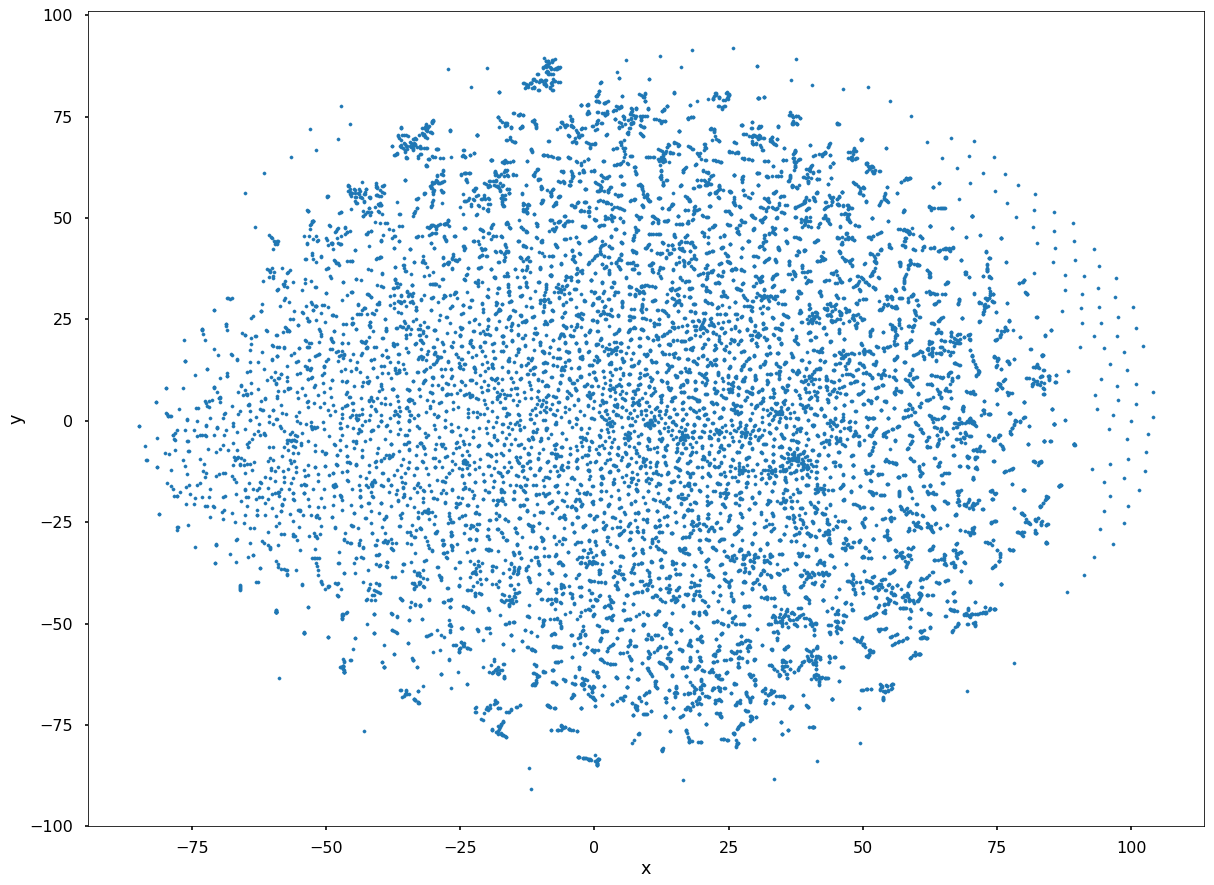

In [91]:
points.plot.scatter("x", "y", s=10, figsize=(20, 15))
plt.savefig('books_read.png')

**Zoom in to some interesting places**

In [46]:
points.to_csv('paintcoords.csv')

In [90]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=15, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=7)

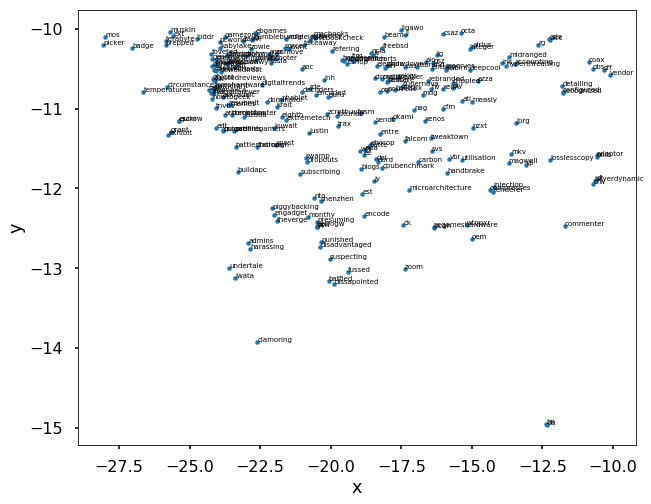

In [168]:
plot_region(x_bounds=(-30, -10), y_bounds=(-30, -10))

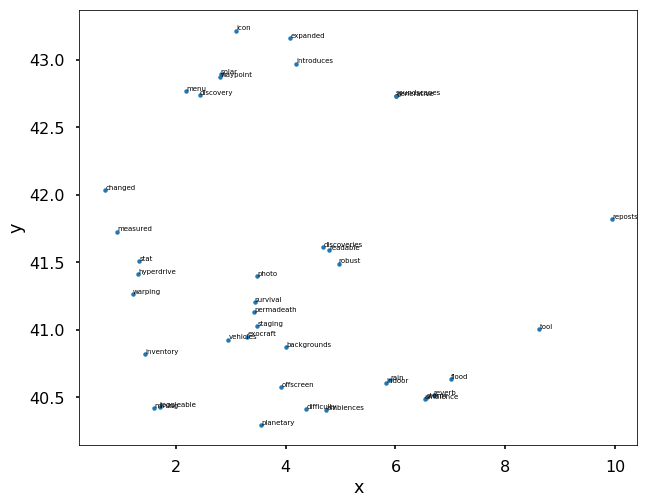

In [181]:
plot_region(x_bounds=(0, 10), y_bounds=(40, 45))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [19]:
model2vec.most_similar("bad",[],100)

[('terrible', 0.7567682862281799),
 ('horrible', 0.7265172004699707),
 ('tacky', 0.6822117567062378),
 ('too_bad', 0.6600064039230347),
 ('messy', 0.6063791513442993),
 ('silly', 0.5927484035491943),
 ('awful', 0.5809243321418762),
 ('ridiculous', 0.5597720742225647),
 ('ugly', 0.558364987373352),
 ('too_expensive', 0.5548003911972046),
 ('weird', 0.5511685013771057),
 ('stupid', 0.5485576391220093),
 ('dumb', 0.5480529069900513),
 ('terribly', 0.5470520257949829),
 ('real', 0.544314980506897),
 ('dated', 0.5411516427993774),
 ('good', 0.5327559113502502),
 ('sad', 0.52665114402771),
 ('poor', 0.5251287221908569),
 ('true', 0.5240137577056885),
 ('uncomfortable', 0.5239009857177734),
 ('harsh', 0.5144562721252441),
 ('bad_idea', 0.5127618908882141),
 ('strange', 0.5114142894744873),
 ('too_busy', 0.5079643726348877),
 ('annoying', 0.5047838091850281),
 ('pretty_cool', 0.49845656752586365),
 ('boring', 0.4925546944141388),
 ('dirty', 0.4918675422668457),
 ('ok', 0.49126261472702026),
 (

In [158]:
model2vec.most_similar("xbox",[],100)

[('xbone', 0.6515986323356628),
 ('sor', 0.6475887298583984),
 ('xxx', 0.6367783546447754),
 ('xbo', 0.6275231838226318),
 ('one', 0.6232575178146362),
 ('xone', 0.6196857690811157),
 ('tba', 0.6163201332092285),
 ('xb', 0.6070624589920044),
 ('pluses', 0.5984342098236084),
 ('imminent', 0.5982304811477661),
 ('xboxx', 0.5961951017379761),
 ('xbones', 0.5937442183494568),
 ('annihilated', 0.5882354974746704),
 ('proceeds', 0.58782559633255),
 ('xboxox', 0.5847378969192505),
 ('undoubtedly', 0.5841379165649414),
 ('dragonball', 0.5780212879180908),
 ('handily', 0.5751073956489563),
 ('adamant', 0.5735440254211426),
 ('trumped', 0.5734425783157349),
 ('thr', 0.5726864337921143),
 ('purchasers', 0.5719538331031799),
 ('compiled', 0.5709279775619507),
 ('differentiator', 0.5699407458305359),
 ('scorpion', 0.5694882273674011),
 ('likewise', 0.5688416361808777),
 ('smallest', 0.5685371160507202),
 ('phat', 0.5670381188392639),
 ('belongs', 0.5665174722671509),
 ('dismal', 0.5665017366409302)

In [147]:
model2vec.most_similar("xbox")

[('xbone', 0.6515986323356628),
 ('sor', 0.6475887298583984),
 ('xxx', 0.6367783546447754),
 ('xbo', 0.6275231838226318),
 ('one', 0.6232575178146362),
 ('xone', 0.6196857690811157),
 ('tba', 0.6163201332092285),
 ('xb', 0.6070624589920044),
 ('pluses', 0.5984342098236084),
 ('imminent', 0.5982304811477661)]

**Linear relationships between word pairs**

In [209]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = model2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [212]:
nearest_similarity_cosmul("lather", "foamy", "fragance")

lather is related to foamy, as unoffensive is related to fragance


'unoffensive'